# iAR package Demo - BIAR Model

In [1]:
import iar
import numpy as np
import matplotlib.pyplot as plt
print("iAR version:")
print(iar.__version__)

iAR version:
1.2.8


# Simulates from a BIAR Model

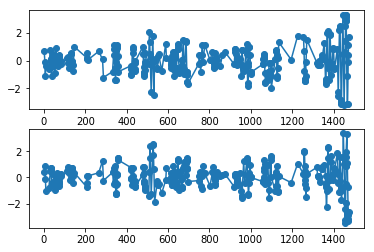

In [2]:
from iar import BIARsample,gentime
np.random.seed(6713)
n=300
phi1=0.9
phi2=0.4
sT=gentime(n=n,lambda1=15,lambda2=2)
y,sT,Sigma =BIARsample(n=n,sT=sT,phi_R=phi1,phi_I=phi2,rho=0.9)
plt.subplot(211)
plt.plot(sT, y[0],"o-")
plt.subplot(212)
plt.plot(sT, y[1],"o-")
plt.show()

# Maximum Likelihood Estimation of the BIAR Model

In [3]:
from iar import BIARphikalman,BIARkalman
y1=np.zeros((2,len(y[0])))
y1[0]=y[0]/np.sqrt(np.var(y[0],ddof=1))
y1[1]=y[1]/np.sqrt(np.var(y[1],ddof=1))
out=BIARphikalman(x=[0.9,0.4],y1=y1[0],y2=y1[1],t=sT,yerr1=np.zeros(len(y1[0])),yerr2=np.zeros(len(y1[0])))
print(out)

-4.172027961116127


In [4]:
phi_R,phi_I,out=BIARkalman(y1=y1[0],y2=y1[1],sT=sT,delta1=np.zeros(len(y1[0])),delta2=np.zeros(len(y1[0])))
print(phi_R)
print(phi_I)

0.9007199213370802
0.4011070425043745


# Estimating Contemporary Correlation

In [5]:
from iar import BIARfit
cor,cov,yhat,xhat,Sighat,Theta,Lambda,Qt=BIARfit(x=(phi_R,phi_I),y1=y1[0],y2=y1[1],t=sT,yerr1=np.zeros(len(y1[0])),yerr2=np.zeros(len(y1[0])))
print(cor)
print(cov)

0.861723717162185
[[0.08240464 0.07761226]
 [0.07761226 0.09844031]]


# Simulates a Negatively Correlated BIAR Model

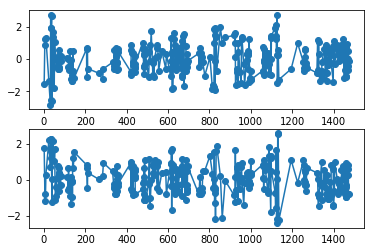

In [6]:
np.random.seed(6713)
n=300
phi1=-0.9
phi2=0.4
sT=gentime(n=n,lambda1=15,lambda2=2)
y,sT,Sigma =BIARsample(n=n,sT=sT,phi_R=phi1,phi_I=phi2,rho=-0.9)
plt.subplot(211)
plt.plot(sT, y[0],"o-")
plt.subplot(212)
plt.plot(sT, y[1],"o-")
plt.show()

In [7]:
y1=np.zeros((2,len(y[0])))
y1[0]=y[0]/np.sqrt(np.var(y[0],ddof=1))
y1[1]=y[1]/np.sqrt(np.var(y[1],ddof=1))
phi_R,phi_I,out=BIARkalman(y1=y1[0],y2=y1[1],sT=sT,delta1=np.zeros(len(y1[0])),delta2=np.zeros(len(y1[0])))
print(phi_R)
print(phi_I)

-0.8948692155723134
0.4027019986263042


In [8]:
cor,cov,yhat,xhat,Sighat,Theta,Lambda,Qt=BIARfit(x=(phi_R,phi_I),y1=y1[0],y2=y1[1],t=sT,yerr1=np.zeros(len(y1[0])),yerr2=np.zeros(len(y1[0])))
print(cor)
print(cov)

-0.8785683711875493
[[ 0.11021392 -0.10475268]
 [-0.10475268  0.12898603]]


# Interpolation with BIAR Model

In [9]:
from iar import BIARinterpolation
np.random.seed(6713)
n=100
phi1=0.9
phi2=0.4
sT=gentime(n=n,lambda1=15,lambda2=2)
y,sT,Sigma =BIARsample(n=n,sT=sT,phi_R=phi1,phi_I=phi2,rho=0.9)
n=len(sT)
p=int(0.9*n)
y0=np.copy(y)
y1=np.zeros((2,100))
y1[0]=(y0[0]-np.mean(y0[0]))/np.sqrt(np.var(y0[0],ddof=1))
y1[1]=(y0[1]-np.mean(y0[1]))/np.sqrt(np.var(y0[1],ddof=1))
#Estimation
phi_R,phi_I,out=BIARkalman(y1=y1[0],y2=y1[1],sT=sT,delta1=np.zeros(len(sT)),delta2=np.zeros(len(sT)))
xest=(phi_R,phi_I)
print(xest)

#Forecast
boolean1=np.isin(np.arange(n),np.arange(p,n))
y1[0][np.where(boolean1)[0]]=np.nan
p1=np.arange(p,n)
xestBIAR=np.zeros(len(p1))
difftime=np.zeros(len(p1))
for i in range(len(p1)):
    pos=p1[range(i+1,len(p1))]
    boolean=np.isin(np.arange(len(sT)),pos)
    y3=y1[0:2,~boolean]
    st3=sT[~boolean]
    difftime[i]=st3[p1[i]]-st3[p1[i]-1]
    xest1,out=BIARinterpolation(x=xest,y1=y3[0],y2=y3[1],t=st3,yerr1=np.zeros(len(st3)),yerr2=np.zeros(len(st3)),nsmooth=1)
    xestBIAR[i]=xest1
    y1[0,p1[i]]=xest1
print(xestBIAR)
MSE=(y0[0,boolean1]-xestBIAR)**2
print(np.mean(MSE))

(0.9010487035688928, 0.39385319200073904)
[ 2.2723958   2.50652836  0.05762539 -2.29186967  1.1301688  -1.76641325
 -0.46007657  0.26109151  0.97275326  1.22932508]
0.23126948724057309


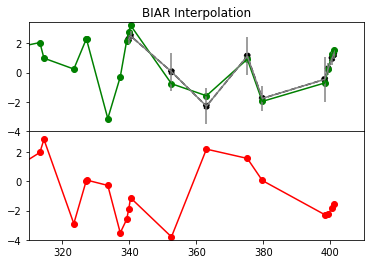

In [10]:
import scipy.stats
ModBIAR=abs(complex(xest[0], xest[1]))
s=np.std(y0[0,:])
yerrBIAR=scipy.stats.norm.ppf(0.975)*s*np.sqrt(1-ModBIAR**(2*difftime))
fig, axs = plt.subplots(2, 1, sharex=True)
fig.subplots_adjust(hspace=0)
axs[0].set_xlim(310,410)
axs[0].set_ylim(np.min(y0)-0.2, np.max(y0)+0.2)
axs[0].plot(sT[np.where(boolean1)[0]], xestBIAR,color="black",linestyle='dashed')
axs[0].scatter(sT[np.where(boolean1)[0]], xestBIAR,color="black",linestyle='dashed')
axs[0].errorbar(sT[np.where(boolean1)[0]], xestBIAR, yerr=yerrBIAR,color="gray")
#plt.plot(sT[np.where(boolean1)[0]], xestCIAR,color="red",linestyle='dashed')
#plt.scatter(sT[np.where(boolean1)[0]], xestCIAR,color="red",linestyle='dashed')
axs[0].plot(sT, y0[0,:],color="green")
axs[0].scatter(sT, y0[0,:],color="green")
axs[1].set_xlim(310,410)
axs[1].set_ylim(np.min(y0)-0.2, np.max(y0)+0.2)
axs[1].plot(sT, y0[1,:],color="red")
axs[1].scatter(sT, y0[1,:],color="red")
axs[0].set_title('BIAR Interpolation')
plt.show()

# Forecast with BIAR Model

In [11]:
from iar import BIARforecast
np.random.seed(6713)
n=100
phi1=0.9
phi2=0.4
sT=gentime(n=n,lambda1=15,lambda2=2)
y,sT,Sigma =BIARsample(n=n,sT=sT,phi_R=phi1,phi_I=phi2,rho=0.9)
n=len(sT)
p=int(0.9*n)
y1=np.zeros((2,100))
y1[0]=(y[0]-np.mean(y[0]))/np.sqrt(np.var(y[0],ddof=1))
y1[1]=(y[1]-np.mean(y[1]))/np.sqrt(np.var(y[1],ddof=1))

#Forecast
ytr=y1[0:2,range(p)]
str=sT[range(p)]
yte=y1[0:2,range(p,n)]
ste=sT[range(p,n)]
n_ahead=ste-str[p-1]
n_ahead2=np.zeros(1)

final=np.zeros(shape=(len(n_ahead),6))
for i in range(10):
    print(i)
    phi_R,phi_I,out=BIARkalman(y1=ytr[0],y2=ytr[1],sT=str,delta1=np.zeros(len(ytr[0])),delta2=np.zeros(len(ytr[0])))
    n_ahead2[0]=ste[i]-str[len(str)-1]
    print(n_ahead2)
    fitted,forBIAR,Lambda2,Sighat2=BIARforecast(x=np.array([phi_R, phi_I]),y1=ytr[0],y2=ytr[1],t=str,tahead=n_ahead2)
    final[i,]=np.hstack((phi_R,yte[0:2,i],forBIAR[0:2,0],n_ahead2))
    ytr=np.hstack((ytr,yte[0:2,[i]]))
    str=np.hstack((str,ste[i]))

0
[0.62287474]
1
[0.54494814]
2
[12.21190914]
3
[10.44844247]
4
[12.21190914]
5
[4.47287754]
6
[18.65844071]
7
[1.00763908]
8
[1.14881638]
9
[0.54494814]


In [12]:
import pandas as pd
forecast=pd.DataFrame(final,columns=["phi","Observed Value 1","Observed Value 2","Forecasted Value 1","Forecasted Value 2","Time Gap"])
forecast

,phi,Observed Value 1,Observed Value 2,Forecasted Value 1,Forecasted Value 2,Time Gap
0,0.892325,0.365663,0.796611,0.370279,0.783410,0.622875
1,0.892407,-0.000075,0.657401,0.283163,0.433856,0.544948
2,0.892325,0.153418,-0.386396,0.661900,-0.715126,12.211909
3,0.891999,0.208350,0.080702,-0.086775,-0.195308,10.448442
4,0.892002,0.228157,-0.343406,-0.076558,-0.233504,12.211909
5,0.891878,-0.256378,-0.260630,0.340797,0.162852,4.472878
6,0.891866,-0.176494,-0.166700,0.417953,-0.117514,18.658441
7,0.891572,0.243056,0.104692,0.213362,-0.301105,1.007639
8,0.891534,-0.142628,0.100579,0.132588,0.315321,1.148816
9,0.891043,-0.058934,0.230096,0.002973,-0.204064,0.544948
